# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [13]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        print('learning_rate: %.10f' % lr)
        print('regularization_strengths: %.10f' % reg)
        svm = LinearSVM() # Always create a new LinearSVM Object
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=3000, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %.10f' % (np.mean(y_train == y_train_pred), ))
                             
        y_val_pred = svm.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)               
        print('validation accuracy: %.10f' % (np.mean(y_val == y_val_pred), ))
        
        results[(lr, reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
        print("------------------------------")
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning_rate: 0.0000000010
regularization_strengths: 50000.0000000000
iteration 0 / 3000: loss 85.921950
iteration 100 / 3000: loss 85.158872
iteration 200 / 3000: loss 84.415149
iteration 300 / 3000: loss 83.651256
iteration 400 / 3000: loss 82.912134
iteration 500 / 3000: loss 82.174419
iteration 600 / 3000: loss 81.455105
iteration 700 / 3000: loss 80.728198
iteration 800 / 3000: loss 80.013064
iteration 900 / 3000: loss 79.301995
iteration 1000 / 3000: loss 78.613874
iteration 1100 / 3000: loss 77.901211
iteration 1200 / 3000: loss 77.222601
iteration 1300 / 3000: loss 76.549652
iteration 1400 / 3000: loss 75.880402
iteration 1500 / 3000: loss 75.211570
iteration 1600 / 3000: loss 74.554698
iteration 1700 / 3000: loss 73.899391
iteration 1800 / 3000: loss 73.252879
iteration 1900 / 3000: loss 72.621678
iteration 2000 / 3000: loss 71.985405
iteration 2100 / 3000: loss 71.356142
iteration 2200 / 3000: loss 70.729878
iteration 2300 / 3000: loss 70.118894
iteration 2400 / 3000: loss 6

iteration 1300 / 3000: loss 9.000246
iteration 1400 / 3000: loss 9.000170
iteration 1500 / 3000: loss 8.999920
iteration 1600 / 3000: loss 9.000064
iteration 1700 / 3000: loss 9.000095
iteration 1800 / 3000: loss 8.999823
iteration 1900 / 3000: loss 9.000009
iteration 2000 / 3000: loss 8.999986
iteration 2100 / 3000: loss 9.000064
iteration 2200 / 3000: loss 8.999903
iteration 2300 / 3000: loss 9.000138
iteration 2400 / 3000: loss 9.000017
iteration 2500 / 3000: loss 9.000008
iteration 2600 / 3000: loss 9.000042
iteration 2700 / 3000: loss 8.999948
iteration 2800 / 3000: loss 9.000152
iteration 2900 / 3000: loss 8.999877
training accuracy: 0.4147346939
validation accuracy: 0.4170000000
------------------------------
learning_rate: 0.0000001000
regularization_strengths: 500000.0000000000
iteration 0 / 3000: loss 785.301955
iteration 100 / 3000: loss 9.027261
iteration 200 / 3000: loss 9.000018
iteration 300 / 3000: loss 9.000011
iteration 400 / 3000: loss 9.000028
iteration 500 / 3000: 

In [14]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.402


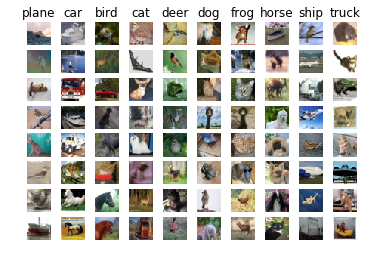

In [29]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

They make sense. 

For some misclassification results which have certain special background, it does make sense. Some of the images with blue background was misclassified as ship(actual is plane) and plane(actual is cat), because of we're using HOG and color histogram. 


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [23]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [28]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

results = {}
best_val = -1
learning_rates = [1e-2, 1e-1, 1, 3]
regularization_strengths = [1e-3, 5e-3, 1e-2, 1e-1, 0.5, 1]

for lr in learning_rates:
    for reg in regularization_strengths:
        print('learning_rate: %.10f' % lr)
        print('regularization_strengths: %.10f' % reg)
        
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                          num_iters=2000, batch_size=200,
                          learning_rate=lr, learning_rate_decay=0.95,
                          reg=reg, verbose=True)

        # Predict on the validation set
        validation_accuracy = (net.predict(X_val_feats) == y_val).mean()
        print('Validation accuracy: ', validation_accuracy)

        results[(lr, reg)] = validation_accuracy
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_net = net
        print("------------------------------")
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % 
          (lr, reg, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning_rate: 0.0100000000
regularization_strengths: 0.0010000000
iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 2.302560
iteration 200 / 2000: loss 2.302447
iteration 300 / 2000: loss 2.302728
iteration 400 / 2000: loss 2.302869
iteration 500 / 2000: loss 2.302175
iteration 600 / 2000: loss 2.302830
iteration 700 / 2000: loss 2.302345
iteration 800 / 2000: loss 2.302366
iteration 900 / 2000: loss 2.302701
iteration 1000 / 2000: loss 2.302050
iteration 1100 / 2000: loss 2.302087
iteration 1200 / 2000: loss 2.301449
iteration 1300 / 2000: loss 2.300656
iteration 1400 / 2000: loss 2.298940
iteration 1500 / 2000: loss 2.297872
iteration 1600 / 2000: loss 2.294246
iteration 1700 / 2000: loss 2.293108
iteration 1800 / 2000: loss 2.283027
iteration 1900 / 2000: loss 2.273901
Validation accuracy:  0.193
------------------------------
learning_rate: 0.0100000000
regularization_strengths: 0.0050000000
iteration 0 / 2000: loss 2.302589
iteration 100 / 2000: loss 2.302694
iteration

iteration 1300 / 2000: loss 2.147350
iteration 1400 / 2000: loss 2.132381
iteration 1500 / 2000: loss 2.125058
iteration 1600 / 2000: loss 2.204935
iteration 1700 / 2000: loss 2.171226
iteration 1800 / 2000: loss 2.130782
iteration 1900 / 2000: loss 2.105133
Validation accuracy:  0.3
------------------------------
learning_rate: 0.1000000000
regularization_strengths: 0.5000000000
iteration 0 / 2000: loss 2.302993
iteration 100 / 2000: loss 2.301784
iteration 200 / 2000: loss 2.300829
iteration 300 / 2000: loss 2.303629
iteration 400 / 2000: loss 2.302848
iteration 500 / 2000: loss 2.305391
iteration 600 / 2000: loss 2.302276
iteration 700 / 2000: loss 2.302974
iteration 800 / 2000: loss 2.303100
iteration 900 / 2000: loss 2.304306
iteration 1000 / 2000: loss 2.302556
iteration 1100 / 2000: loss 2.302408
iteration 1200 / 2000: loss 2.302841
iteration 1300 / 2000: loss 2.298913
iteration 1400 / 2000: loss 2.303194
iteration 1500 / 2000: loss 2.301346
iteration 1600 / 2000: loss 2.301751


/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/neural_net.py:99: RuntimeWarning: divide by zero encountered in log
  cross_entropy_loss = np.sum(-1 * np.log(softmax[np.arange(N), y]))


iteration 100 / 2000: loss inf
iteration 200 / 2000: loss inf
iteration 300 / 2000: loss inf
iteration 400 / 2000: loss inf
iteration 500 / 2000: loss inf
iteration 600 / 2000: loss inf
iteration 700 / 2000: loss inf
iteration 800 / 2000: loss inf


/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/neural_net.py:97: RuntimeWarning: overflow encountered in subtract
  scores = scores - np.max(scores, axis=1, keepdims=True)
/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/neural_net.py:97: RuntimeWarning: invalid value encountered in subtract
  scores = scores - np.max(scores, axis=1, keepdims=True)
/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/neural_net.py:101: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
/home/shared/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/yxue/stanford-cs231n-spring1718/assignment1/cs231n/classifiers/neural_net.py:121: RuntimeWarning: invalid value encountered in greater
  dh = (a1 > 0) * da  # back-propagation pass ReLU


iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
Validation accuracy:  0.087
------------------------------
learning_rate: 3.0000000000
regularization_strengths: 0.0010000000
iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 1.929803
iteration 200 / 2000: loss 1.589820
iteration 300 / 2000: loss 1.557048
iteration 400 / 2000: loss 1.808782
iteration 500 / 2000: loss 1.588996
iteration 600 / 2000: loss 1.639925
iteration 700 / 2000: loss 1.696341
iteration 800 / 2000: loss 1.646278
iteration 900 / 2000: loss 1.616090
iteration 1000 / 2000: loss 1.669480
iteration 1100 / 2000: loss 1.657507
iteration 1200 / 2000: loss 1.563848
iteration 1300 / 2000: loss 1.649461
iteration 1400 / 

/home/shared/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
Validation accuracy:  0.087
------------------------------
learning_rate: 3.0000000000
regularization_strengths: 1.0000000000
iteration 0 / 2000: loss 2.303399
iteration 100 / 2000: loss inf
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: l

In [30]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.575
